In [6]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import time
from tqdm import tqdm
import seaborn as sns #not needed to run program
import matplotlib.pyplot as plt #not needed to run program
import datetime
#import copy
import logging
from pypfopt import risk_models, expected_returns, EfficientFrontier, objective_functions #, plotting
import itertools
import warnings
import plotly.express as px

In [7]:
logging.basicConfig(format = '%(asctime)s:%(levelname)s :%(message)s',
                        datefmt = '%Y-%m-%d %H:%M:%S',
                        filename = 'logs/run_main.log',
                        level=logging.INFO)

**1. Get current DAX constituents from wikipedia**

In [8]:
def replace_by_freq(dataframe, column_name, threshold, new_value):

    """
    Replace values in a column of a DataFrame based on their frequency count.

    Args:
        dataframe (pandas.DataFrame): The DataFrame to modify.
        column_name (str): The name of the column to replace values in.
        threshold (int): The frequency threshold. Values appearing less than this threshold will be replaced.
        new_value: The new value to replace the infrequent values with.

    Returns:
        pandas.DataFrame: The modified DataFrame with values replaced.

    Raises:
        KeyError: If the specified column is not found in the DataFrame.
        
    """

    try:
        unique = dataframe.groupby(column_name)[column_name].transform('size').lt(threshold)
        dataframe.loc[unique, column_name] = new_value
    except KeyError as ke:
        print(f'Column ', ke, 'is not found in a dataframe')
    
    return dataframe

In [9]:
def dax40_latest_constituents():
    
    """
    Retrieve the latest constituents of the DAX40 index from Wikipedia (https://en.wikipedia.org/wiki/DAX).

     Args:
       None

    Returns:
        pandas.DataFrame: DataFrame containing the latest DAX40 constituents.

    Raises:
        Exception: If the website URL is unreachable or does not exist.
        Exception: If the 'constituents' table cannot be found on the website.
        Exception: If there is an error while extracting columns from the table.
        KeyError: If there is an issue with the column index of the 'constituents' table.

    """

    url = 'https://en.wikipedia.org/wiki/DAX'
    response = requests.get(url, verify = False)

    #Check if the connection is succesful
    try:
        response = requests.get(url, verify = False)
        if response.ok:
            soup = BeautifulSoup(response.text, 'html.parser')
        else:
            raise Exception(f'Cannot reach website {url}')
    except:
        raise Exception(f'Website {url} does not exist')

    #check if table 'constituents' exists
    wiki_table_id = 'constituents'
    try:
        indiatable = soup.find('table',{'id': wiki_table_id,'class':'wikitable'})
        df = pd.read_html(str(indiatable))
    except:
        raise Exception(f'Table {wiki_table_id} cannot be found in {url}')

    #Extract columns from table
    extract_cols = ['Ticker', 'Company', 'Prime Standard Sector']
    try:
        dax_constituents = pd.DataFrame(df[0])[extract_cols]
        dax_constituents = dax_constituents.rename(columns = {'Prime Standard Sector': 'Sector', 'Company': 'Name'})
    except KeyError as e:
        raise Exception((e.args[0]).replace('index', 'column index of table constituents'))

    dax_constituents = replace_by_freq(dax_constituents, 'Sector', 2, 'Other')

    logging.info(f'DAX40 constituents loaded successfully')

    return dax_constituents

In [10]:
# #Test
dax_comp = dax40_latest_constituents()
# print(dax_comp.head(20))

c:\Users\48512\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'en.wikipedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\48512\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'en.wikipedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<AxesSubplot:xlabel='Sector'>

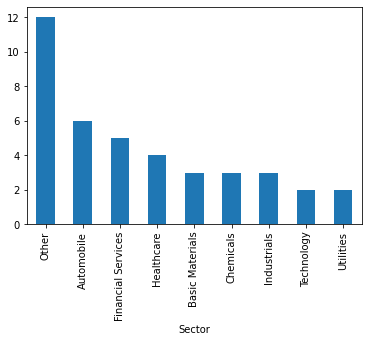

In [11]:
dax_comp.groupby(['Sector'])['Sector'].count().sort_values(ascending=False).plot.bar()

In [12]:
dax_comp.head(5)

,Ticker,Name,Sector
0,ADS.DE,Adidas,Other
1,AIR.DE,Airbus,Other
2,ALV.DE,Allianz,Financial Services
3,BAS.DE,BASF,Basic Materials
4,BAYN.DE,Bayer,Healthcare


In [13]:
def column_to_list_from_df(df, column_name):

    """
    Retrieve the values from a specific column in a DataFrame and convert them to a list.

    Args:
        df (pandas.DataFrame): The DataFrame containing the desired column.
        column_name (str): The name of the column to extract values from.

    Returns:
        list: A list containing the values from the specified column.

    Raises:
        KeyError: If the specified column does not exist in the DataFrame.
        Exception: If an error occurs while retrieving the column values.
        
    """

    try:
        output = df[column_name].values.tolist()
        return output
    except KeyError:
        raise KeyError(f"Column '{column_name}' does not exist in the DataFrame.")
    except:
        raise Exception("An error occurred while retrieving the column values.")


In [14]:
#A list of tickers from contituents
dax_tickers = column_to_list_from_df(dax_comp, 'Ticker')

In [15]:
print(dax_tickers)

['ADS.DE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE', 'BMW.DE', 'BNR.DE', 'CBK.DE', 'CON.DE', '1COV.DE', 'DTG.DE', 'DBK.DE', 'DB1.DE', 'DPW.DE', 'DTE.DE', 'EOAN.DE', 'FRE.DE', 'HNR1.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'MBG.DE', 'MRK.DE', 'MTX.DE', 'MUV2.DE', 'P911.DE', 'PAH3.DE', 'QIA.DE', 'RHM.DE', 'RWE.DE', 'SAP.DE', 'SRT3.DE', 'SIE.DE', 'ENR.DE', 'SHL.DE', 'SY1.DE', 'VOW3.DE', 'VNA.DE', 'ZAL.DE']


**2.Download monthly data from yahoo API**

In [16]:
def get_stock_price(ticker, start_date = "2001-04-01", end_date = "2023-01-01", price_interval = '1mo'):

    """
    Retrieve historical stock prices for a given ticker symbol within a specified time period and price interval.

    Args:
        ticker (str): Ticker symbol of the stock.
        start_date (str, optional): Start date of the desired time period in 'YYYY-MM-DD' format. Default is '2001-04-01'.
        end_date (str, optional): End date of the desired time period in 'YYYY-MM-DD' format. Default is '2023-01-01'.
        price_interval (str, optional): Interval at which to retrieve stock prices. Acceptable values are: '1m', '2m', '5m',
            '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'. Default is '1mo'.

    Returns:
        pandas.Series: Series containing the closing stock prices.

    Raises:
        ValueError: If the specified price interval is not in the list of acceptable interval types.
        ValueError: If the stock either does not exist or does not have data for the given time period.
    
    """


    interval_types = ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

    if price_interval not in interval_types:
        raise ValueError(f'Unknown interval type: {price_interval}. Acceptable arguments are {interval_types}')
    

    stock_data = yf.Ticker(ticker)
    stock_series = stock_data.history(start = start_date, end = end_date, interval = price_interval).Close

    if stock_series.empty:
        raise ValueError(f'{ticker} either does not exist or does not have data for a given time period')

    return stock_series


In [17]:
def convert_datetime_index_to_date(df):

    """
    Convert the datetime index of a DataFrame to date only.

    Args:
        df (pandas.DataFrame): The DataFrame to convert.

    Returns:
        pandas.DataFrame: The DataFrame with the datetime index converted to date only.

    Raises:
        Exception: If an AttributeError occurs during the conversion process.
    
    """    

    try:
        df.index = pd.to_datetime(df.index.date)
    except AttributeError as e:
        raise Exception(f'Could not convert index of a dataframe to date. Error message: {e}')
    return df

In [18]:
def get_data(tickers):

    """
    Retrieve historical stock price data for a list of tickers.

    Args:
        tickers (list): List of ticker symbols for the stocks.

    Returns:
        pandas.DataFrame: DataFrame containing historical stock price data for the given tickers.

    """

    output = {}
    tickers_downloaded = []

    with tqdm(total = len(tickers)) as pbar:
        for one_ticker in tickers:
            pbar.set_postfix_str(one_ticker)
            try:
                stock_price = get_stock_price(ticker = one_ticker)
                output[one_ticker] = stock_price
                tickers_downloaded.append(one_ticker)
            except ValueError as e:
                logging.warning(f'Non-existent ticker {one_ticker} or no data for given time interval')
                pass
            pbar.update()
            time.sleep(0.5)
    
    output = pd.DataFrame(output)
    output = convert_datetime_index_to_date(output)

    logging.info(f'Successfully downloaded stocks {tickers_downloaded}')
    
    return output

In [19]:
# dax_tickers_sample = ['ADS.DEE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DEE', '1COV.DE']

In [20]:
dax_data = get_data(tickers = dax_tickers)

100%|██████████| 40/40 [01:07<00:00,  1.68s/it, ZAL.DE] 


In [21]:
# dax_data.head(5)

In [22]:
# plt.figure(figsize=(19,12))
# sns.heatmap(dax_data.isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# plt.savefig("dax40_missing_values.png", dpi=100)

In [23]:
def drop_columns_with_na(df):

    """
    Drop columns from a DataFrame that contain any missing values (NA).

    Args:
        df (pandas.DataFrame): The DataFrame to process.

    Returns:
        pandas.DataFrame: The DataFrame with columns containing missing values dropped.

    Raises:
        Exception: If an error occurs while dropping columns with NA.

    """

    try:
        columns_contain_na = df.columns[df.isnull().any()].tolist()
        df_dropped = df.drop(columns=columns_contain_na)
    except:
        raise Exception('Could not drop columns with NA')

    logging.info(f'{(columns_contain_na)} contain NA values. They are dropped from the dataframe')

    return df_dropped

In [24]:
dax_data = drop_columns_with_na(dax_data)

In [25]:
# plt.figure(figsize=(19,12))
# sns.heatmap(dax_data.isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# #plt.savefig("dax40_missing_values.png", dpi=100)

In [26]:
print(dax_data.tail(5))

                ADS.DE      AIR.DE      ALV.DE     BAS.DE    BAYN.DE  \
2022-08-01  147.658981   96.490471  159.882050  39.089729  50.487549   
2022-09-01  118.382111   87.646904  153.451874  36.794704  45.510784   
2022-10-01   98.565460  108.015686  172.799316  42.216354  51.082649   
2022-11-01  121.747963  107.739639  193.806488  45.078163  53.155903   
2022-12-01  126.926178  109.810036  190.534485  43.103699  46.384235   

                BEI.DE     BMW.DE    CBK.DE     CON.DE     DBK.DE  ...  \
2022-08-01  100.022079  67.708977  6.488936  56.123058   8.063096  ...   
2022-09-01  100.370064  64.501854  7.185787  44.865250   7.407237  ...   
2022-10-01   96.621727  73.284569  7.923744  51.241093   9.358345  ...   
2022-11-01  103.352829  79.542145  7.835659  55.927780   9.805918  ...   
2022-12-01  106.584160  76.841896  8.648001  54.658470  10.257366  ...   

               MBG.DE      MRK.DE     MUV2.DE     QIA.DE      RHM.DE  \
2022-08-01  51.965923  169.080215  230.027496  45.

In [27]:
def price_to_returns(df):
    
    """
    Calculate the returns for stock prices.

    Args:
        df (pandas.DataFrame): A DataFrame containing stock prices.
            The DataFrame should have numerical columns representing the stock prices.

    Returns:
        pandas.DataFrame: A new DataFrame containing the calculated returns.
            The returned DataFrame will have the same columns as the input DataFrame,
            but with the first row dropped since it contains NaN values.
    """
    
    df_returns = df.pct_change().dropna()

    return df_returns


In [28]:
dax_returns = price_to_returns(dax_data)

In [29]:
#print(dax_returns.head(5))

**3.1 Mimumum variance portfolio** <br>
*Machine learning approach - tunning hyperparameters to achieve portfolio with least variance*

In [30]:
#Use: exponential covariance matrix, returns : exponential moving average
#You can pass reuturns to expected_returns and risk_models methods

#USeful links: 
#https://github.com/robertmartin8/PyPortfolioOpt/tree/master/cookbook
#https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html


In [31]:
#at least two time series should be to do mvp

In [32]:
def portfolio_name(cov_est, mu_est, penalty):
    """
    Generates a portfolio name based on the given covariance estimation method, mean estimation method, and penalty value.

    Args:
        cov_est (str): The covariance estimation method.`
        mu_est (str): The mean estimation method.
        penalty (float): The penalty value.

    Returns:
        str: The generated portfolio name.

    Raises:
        KeyError: If the provided covariance or mean estimation method is not implemented.
    """
    cov_est_encoding = {
        "sample_cov": 'sample',
        "semicovariance": 'semi',
        "exp_cov": 'exp',
        "ledoit_wolf": 'lw',
        "ledoit_wolf_constant_variance": 'lwcv',
        "ledoit_wolf_single_factor": 'lwsf',
        "ledoit_wolf_constant_correlation": 'lwcc',
        "oracle_approximating": 'oa'
    }

    mu_est_encoding = {
        "mean_historical_return": 'mean',
        "ema_historical_return": 'ema',
        "capm_return": 'capm'
    }

    port_name_template = 'port_{cov_est_name}_{mu_est_name}_{penalty_value}'

    try:
        port_name = port_name_template.format(
            cov_est_name=cov_est_encoding[cov_est],
            mu_est_name=mu_est_encoding[mu_est],
            penalty_value=penalty
        )
        return port_name

    except KeyError as k:
        raise KeyError(f'{k} is not implemented')


In [33]:
def min_var_portfolio(df_returns, cov_est="sample_cov", mu_est="mean_historical_return", penalty=0):
    """
    Computes the minimum variance portfolio weights.

    Parameters:
        df_returns (pandas.DataFrame): DataFrame containing asset returns.
        cov_est (str, optional): Method to estimate the covariance matrix. Defaults to "sample_cov".
        mu_est (str, optional): Method to estimate expected returns. Defaults to "mean_historical_return".
        penalty (float, optional): L2 regularization penalty. Defaults to 0.

    Returns:
        dict or None: Dictionary of asset weights for the minimum variance portfolio or None if an error occurs.

    Raises:
        ValueError: If the DataFrame has less than 2 columns.
        Exception: If an error occurs during the computation, an exception is raised with an error message.
    """
    if df_returns.shape[1] < 2:
        raise ValueError("DataFrame must have at least 2 columns.")

    try:
        mu = expected_returns.return_model(prices=df_returns, returns_data=True, frequency=12, method=mu_est)
        cov_mat = risk_models.risk_matrix(prices=df_returns, returns_data=True, frequency=12, method=cov_est)
        cov_mat_fix = risk_models.fix_nonpositive_semidefinite(matrix=cov_mat)

        ef = EfficientFrontier(expected_returns=mu, cov_matrix=cov_mat_fix)
        ef.add_objective(objective_functions.L2_reg, gamma=penalty)
        ef.min_volatility()

        weights = ef.clean_weights()

        return weights
    except Exception as e:
        raise Exception(f'Error message: {e}')

In [34]:
def portfolio_performance(df_returns, is_period=24, cov_est="sample_cov", mu_est="mean_historical_return", penalty=0):
    """
    Calculates the out-of-sample portfolio returns based on the given historical returns data and parameters.

    Args:
        df_returns (pandas.DataFrame): Historical returns data as a DataFrame.
        is_period (int, optional): Length of the in-sample period. Defaults to 24.
        cov_est (str, optional): Covariance estimation method. Defaults to "sample_cov".
        mu_est (str, optional): Mean estimation method. Defaults to "mean_historical_return".
        penalty (float, optional): Penalty value. Defaults to 0.

    Returns:
        pandas.Series: Out-of-sample portfolio returns.

    Raises:
        KeyError: If the provided covariance or mean estimation method is not implemented.
    """
    port_name = portfolio_name(cov_est=cov_est, mu_est=mu_est, penalty=penalty)

    n = df_returns.shape[0]  # number of observations - 260
    n_is = is_period  # length of in-sample period
    n_oos = n - n_is # length of out-of-sample period - 236

    date_oos = df_returns.iloc[n_is:n].index
    port_return_oos = []

    for i in range(n_oos):
        try:
            is_index = list(range(i, i + n_is))
            oos_index = n_is + i

            returns_is = df_returns.iloc[is_index,]
            returns_oos = df_returns.iloc[oos_index]

            port_weights = min_var_portfolio(df_returns=returns_is, cov_est=cov_est, mu_est=mu_est, penalty=penalty)

            #function?
            np_weights = pd.Series(port_weights).sort_index().to_numpy()
            np_returns_oos = returns_oos.sort_index().to_numpy()
            port_return_oos_scalar = np.dot(np_weights, np_returns_oos)
            #
            port_return_oos.append(port_return_oos_scalar)
        except KeyError as k:
            raise KeyError(f'{k} is not implemented')

    port_return_oos = pd.Series(data=port_return_oos, index=date_oos, name=port_name)

    return port_return_oos


In [35]:
def tune_portfolio(df_returns, is_period=24, param_values = {'cov_est':["sample_cov"], 'mu_est':['mean_historical_return'], 'penalty':[0]}):
    """
    Tune portfolio based on different parameter combinations.

    Parameters:
        df_returns (DataFrame): Historical returns data.
        is_period (int): Number of periods.
        param_values (dict): Dictionary of parameter values.

    Returns:
        DataFrame: Results of the tuned portfolio.

    """
    est_progress_template = 'Covariance matrix: {cov_est} | Expected retuns: {mu_est} | Penalty value: {penalty}'
    param_combinations = list(itertools.product(*param_values.values()))
    output = {}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        with tqdm(total = len(param_combinations)) as pbar:
            
            for params in param_combinations:
                hyperparam = dict(zip(param_values.keys(), params))
                est_progress = est_progress_template.format(cov_est = hyperparam['cov_est'],
                                                    mu_est = hyperparam['mu_est'],
                                                    penalty = hyperparam['penalty'])
                
                pbar.set_postfix_str(est_progress)
                
                try:
                    port_returns = portfolio_performance(df_returns=df_returns, is_period=is_period, **hyperparam)
                    output[port_returns.name] = port_returns
                except Exception as e:
                    print(f"Error occurred for hyperparameters: {hyperparam}. Error: {str(e)}")
                
                pbar.update()

    df_results = pd.DataFrame(output)

    return df_results

In [36]:
hyperparam_values = {
    'cov_est': ["sample_cov", "semicovariance", "ledoit_wolf", "oracle_approximating"],
    'mu_est': ["mean_historical_return"],
    'penalty': [0, 0.25, 0.5, 1, 2, 4, 8]
}

In [37]:
mvp_many = tune_portfolio(df_returns=dax_returns, is_period = 24, param_values=hyperparam_values)

 75%|███████▌  | 21/28 [01:44<00:30,  4.42s/it, Covariance matrix: oracle_approximating | Expected retuns: mean_historical_return | Penalty value: 0]

Error occurred for hyperparameters: {'cov_est': 'ledoit_wolf', 'mu_est': 'mean_historical_return', 'penalty': 8}. Error: Error message: ARPACK error -1: ARPACK error -1: No convergence (291 iterations, 0/1 eigenvectors converged)


        CVXPY note: This failure was encountered while trying to certify
        that a matrix is positive semi-definite (see [1] for a definition).
        In rare cases, this method fails for numerical reasons even when the matrix is
        positive semi-definite. If you know that you're in that situation, you can
        replace the matrix A by cvxpy.psd_wrap(A).

        [1] https://en.wikipedia.org/wiki/Definite_matrix
        


 79%|███████▊  | 22/28 [01:46<00:21,  3.65s/it, Covariance matrix: oracle_approximating | Expected retuns: mean_historical_return | Penalty value: 0.25]

Error occurred for hyperparameters: {'cov_est': 'oracle_approximating', 'mu_est': 'mean_historical_return', 'penalty': 0}. Error: Error message: ARPACK error -1: ARPACK error -1: No convergence (291 iterations, 0/1 eigenvectors converged)


        CVXPY note: This failure was encountered while trying to certify
        that a matrix is positive semi-definite (see [1] for a definition).
        In rare cases, this method fails for numerical reasons even when the matrix is
        positive semi-definite. If you know that you're in that situation, you can
        replace the matrix A by cvxpy.psd_wrap(A).

        [1] https://en.wikipedia.org/wiki/Definite_matrix
        


 93%|█████████▎| 26/28 [02:00<00:06,  3.23s/it, Covariance matrix: oracle_approximating | Expected retuns: mean_historical_return | Penalty value: 4]   

Error occurred for hyperparameters: {'cov_est': 'oracle_approximating', 'mu_est': 'mean_historical_return', 'penalty': 2}. Error: Error message: ARPACK error -1: ARPACK error -1: No convergence (291 iterations, 0/1 eigenvectors converged)


        CVXPY note: This failure was encountered while trying to certify
        that a matrix is positive semi-definite (see [1] for a definition).
        In rare cases, this method fails for numerical reasons even when the matrix is
        positive semi-definite. If you know that you're in that situation, you can
        replace the matrix A by cvxpy.psd_wrap(A).

        [1] https://en.wikipedia.org/wiki/Definite_matrix
        


100%|██████████| 28/28 [02:10<00:00,  4.65s/it, Covariance matrix: oracle_approximating | Expected retuns: mean_historical_return | Penalty value: 8]


In [38]:
print(mvp_many)

            port_sample_mean_0  port_sample_mean_0.25  port_sample_mean_0.5  \
2003-05-01            0.019899               0.023876              0.028242   
2003-06-01            0.016596               0.031015              0.037606   
2003-07-01            0.019017               0.059385              0.068175   
2003-08-01            0.034575               0.029469              0.033019   
2003-09-01           -0.022327              -0.031509             -0.031408   
...                        ...                    ...                   ...   
2022-08-01           -0.042446              -0.041518             -0.042887   
2022-09-01           -0.037660              -0.049696             -0.051441   
2022-10-01            0.055966               0.049120              0.059318   
2022-11-01            0.080850               0.087558              0.090059   
2022-12-01           -0.005332              -0.006740             -0.011047   

            port_sample_mean_1  port_sample_mean_2 

Plot scatterplot of minimum variance portfolios

In [39]:
def annual_expected_returns(monthly_returns):
    """
    Calculate the annual expected returns from monthly returns.

    Parameters:
        monthly_returns (array-like): A sequence of monthly returns.

    Returns:
        float or None: The annual returns calculated from the mean of monthly returns, rounded to four decimal places.
                       Returns None if an error occurs during the calculation.

    Raises:
        None.
    """
    try:
        return_pa = monthly_returns.mean() * 12
        return_pa_round = np.round(return_pa, 4)
        return return_pa_round
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [40]:
def annual_volatility(monthly_returns):

    """
    Calculate the annual volatility of returns returns.

    Parameters:
        monthly_returns (array-like): A sequence of monthly stock returns.

    Returns:
        float or None: The annual volatility of the stock returns, rounded to four decimal places.
                       Returns None if an error occurs during the calculation.

    Raises:
        ValueError: If the length of monthly_returns is less than 2.
    """

    if len(monthly_returns) < 2:
            raise ValueError("At least two stock returns are required to calculate volatility.")    
    try:
        volatility_pa = monthly_returns.std()*np.sqrt(12)
        volatility_pa_round = np.round(volatility_pa, 4)
        return volatility_pa_round
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [42]:
mvp_expected_returns_pa = {col: annual_expected_returns(mvp_many[col]) for col in mvp_many.columns}

In [43]:
mvp_volatility_pa = {col: annual_volatility(mvp_many[col]) for col in mvp_many.columns}

In [44]:
print(mvp_expected_returns_pa)

{'port_sample_mean_0': 0.115, 'port_sample_mean_0.25': 0.1252, 'port_sample_mean_0.5': 0.1279, 'port_sample_mean_1': 0.1308, 'port_sample_mean_2': 0.1338, 'port_sample_mean_4': 0.1357, 'port_sample_mean_8': 0.1377, 'port_semi_mean_0': 0.1042, 'port_semi_mean_0.25': 0.1266, 'port_semi_mean_0.5': 0.1269, 'port_semi_mean_1': 0.1293, 'port_semi_mean_2': 0.132, 'port_semi_mean_4': 0.1357, 'port_semi_mean_8': 0.138, 'port_lw_mean_0': 0.1243, 'port_lw_mean_0.25': 0.1274, 'port_lw_mean_0.5': 0.1294, 'port_lw_mean_1': 0.1325, 'port_lw_mean_2': 0.1348, 'port_lw_mean_4': 0.1368, 'port_oa_mean_0.25': 0.1262, 'port_oa_mean_0.5': 0.1287, 'port_oa_mean_1': 0.1318, 'port_oa_mean_4': 0.1363, 'port_oa_mean_8': 0.1382}


In [45]:
print(mvp_volatility_pa)

{'port_sample_mean_0': 0.1485, 'port_sample_mean_0.25': 0.1506, 'port_sample_mean_0.5': 0.157, 'port_sample_mean_1': 0.1641, 'port_sample_mean_2': 0.1706, 'port_sample_mean_4': 0.1755, 'port_sample_mean_8': 0.1789, 'port_semi_mean_0': 0.1594, 'port_semi_mean_0.25': 0.1532, 'port_semi_mean_0.5': 0.1605, 'port_semi_mean_1': 0.1666, 'port_semi_mean_2': 0.1722, 'port_semi_mean_4': 0.1769, 'port_semi_mean_8': 0.1799, 'port_lw_mean_0': 0.1433, 'port_lw_mean_0.25': 0.1556, 'port_lw_mean_0.5': 0.162, 'port_lw_mean_1': 0.1684, 'port_lw_mean_2': 0.1738, 'port_lw_mean_4': 0.1777, 'port_oa_mean_0.25': 0.1547, 'port_oa_mean_0.5': 0.161, 'port_oa_mean_1': 0.1675, 'port_oa_mean_4': 0.1772, 'port_oa_mean_8': 0.18}


In [46]:
mvp_ret_vol = {
    "expected_returns": mvp_expected_returns_pa,
    "volatility": mvp_volatility_pa
}
df_mvp = pd.DataFrame(mvp_ret_vol)
print(df_mvp)


                       expected_returns  volatility
port_sample_mean_0               0.1150      0.1485
port_sample_mean_0.25            0.1252      0.1506
port_sample_mean_0.5             0.1279      0.1570
port_sample_mean_1               0.1308      0.1641
port_sample_mean_2               0.1338      0.1706
port_sample_mean_4               0.1357      0.1755
port_sample_mean_8               0.1377      0.1789
port_semi_mean_0                 0.1042      0.1594
port_semi_mean_0.25              0.1266      0.1532
port_semi_mean_0.5               0.1269      0.1605
port_semi_mean_1                 0.1293      0.1666
port_semi_mean_2                 0.1320      0.1722
port_semi_mean_4                 0.1357      0.1769
port_semi_mean_8                 0.1380      0.1799
port_lw_mean_0                   0.1243      0.1433
port_lw_mean_0.25                0.1274      0.1556
port_lw_mean_0.5                 0.1294      0.1620
port_lw_mean_1                   0.1325      0.1684
port_lw_mean

In [47]:
fig = px.scatter(df_mvp, x = "volatility", y = "expected_returns")
fig.show()

In [94]:
#portfolio with least volatility
mvp_best = df_mvp[df_mvp.volatility == df_mvp.volatility.min()]

In [95]:
print(mvp_best)

                expected_returns  volatility
port_lw_mean_0            0.1243      0.1433


In [49]:
oos_index = mvp_many.index
oos_index

DatetimeIndex(['2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01', '2003-11-01', '2003-12-01',
               '2004-01-01', '2004-02-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=236, freq=None)

In [50]:
print(mvp_many)

            port_sample_mean_0  port_sample_mean_0.25  port_sample_mean_0.5  \
2003-05-01            0.019899               0.023876              0.028242   
2003-06-01            0.016596               0.031015              0.037606   
2003-07-01            0.019017               0.059385              0.068175   
2003-08-01            0.034575               0.029469              0.033019   
2003-09-01           -0.022327              -0.031509             -0.031408   
...                        ...                    ...                   ...   
2022-08-01           -0.042446              -0.041518             -0.042887   
2022-09-01           -0.037660              -0.049696             -0.051441   
2022-10-01            0.055966               0.049120              0.059318   
2022-11-01            0.080850               0.087558              0.090059   
2022-12-01           -0.005332              -0.006740             -0.011047   

            port_sample_mean_1  port_sample_mean_2 

In [51]:
oos_dax_returns = dax_returns.loc[oos_index,]

In [52]:
oos_dax_returns.index.equals(mvp_many.index)


True

In [53]:
print(oos_dax_returns)
#print(mvp_many)

              ADS.DE    AIR.DE    ALV.DE    BAS.DE   BAYN.DE    BEI.DE  \
2003-05-01 -0.029831  0.083624  0.041775 -0.078059  0.122710  0.054668   
2003-06-01  0.008448  0.221607  0.123913  0.045839  0.161773  0.002835   
2003-07-01  0.002686  0.295455  0.312518  0.141129  0.050545 -0.067430   
2003-08-01  0.021428  0.002807 -0.145158 -0.012014 -0.081604  0.078788   
2003-09-01 -0.017307 -0.075577 -0.066617 -0.101096 -0.047252 -0.051513   
...              ...       ...       ...       ...       ...       ...   
2022-08-01 -0.116329 -0.067727 -0.049289 -0.030980 -0.077193 -0.000497   
2022-09-01 -0.198274 -0.091652 -0.040218 -0.058712 -0.098574  0.003479   
2022-10-01 -0.167396  0.232396  0.126082  0.147349  0.122430 -0.037345   
2022-11-01  0.235199 -0.002556  0.121570  0.067789  0.040586  0.069664   
2022-12-01  0.042532  0.019217 -0.016883 -0.043801 -0.127393  0.031265   

              BMW.DE    CBK.DE    CON.DE    DBK.DE  ...    MBG.DE    MRK.DE  \
2003-05-01 -0.016739  0.101695  

In [54]:
dax_expected_returns_pa = {col: annual_expected_returns(oos_dax_returns[col]) for col in oos_dax_returns.columns}

In [55]:
dax_volatility_pa = {col: annual_volatility(oos_dax_returns[col]) for col in oos_dax_returns.columns}

In [56]:
print(dax_expected_returns_pa)

{'ADS.DE': 0.1466, 'AIR.DE': 0.2156, 'ALV.DE': 0.1399, 'BAS.DE': 0.1224, 'BAYN.DE': 0.1208, 'BEI.DE': 0.0883, 'BMW.DE': 0.1233, 'CBK.DE': 0.0064, 'CON.DE': 0.1662, 'DBK.DE': 0.0289, 'DB1.DE': 0.1377, 'DPW.DE': 0.139, 'DTE.DE': 0.0984, 'EOAN.DE': 0.0681, 'FRE.DE': 0.1421, 'HNR1.DE': 0.1541, 'HEI.DE': 0.1176, 'HEN3.DE': 0.1027, 'IFX.DE': 0.212, 'MBG.DE': 0.1343, 'MRK.DE': 0.1836, 'MUV2.DE': 0.1254, 'QIA.DE': 0.1636, 'RHM.DE': 0.2067, 'RWE.DE': 0.1154, 'SAP.DE': 0.1187, 'SRT3.DE': 0.3904, 'SIE.DE': 0.118, 'VOW3.DE': 0.1907}


In [57]:
print(dax_volatility_pa)

{'ADS.DE': 0.264, 'AIR.DE': 0.3476, 'ALV.DE': 0.2787, 'BAS.DE': 0.2595, 'BAYN.DE': 0.2562, 'BEI.DE': 0.1829, 'BMW.DE': 0.2797, 'CBK.DE': 0.4405, 'CON.DE': 0.3843, 'DBK.DE': 0.3619, 'DB1.DE': 0.2813, 'DPW.DE': 0.2744, 'DTE.DE': 0.2155, 'EOAN.DE': 0.252, 'FRE.DE': 0.2419, 'HNR1.DE': 0.215, 'HEI.DE': 0.3439, 'HEN3.DE': 0.2086, 'IFX.DE': 0.5372, 'MBG.DE': 0.329, 'MRK.DE': 0.2422, 'MUV2.DE': 0.2064, 'QIA.DE': 0.3711, 'RHM.DE': 0.3614, 'RWE.DE': 0.2984, 'SAP.DE': 0.2309, 'SRT3.DE': 0.3768, 'SIE.DE': 0.2551, 'VOW3.DE': 0.3821}


In [58]:
dax_ret_vol = {
    "expected_returns": dax_expected_returns_pa,
    "volatility": dax_volatility_pa
}
df_dax = pd.DataFrame(dax_ret_vol).reset_index()
df_dax = df_dax.rename(columns={"index":"Ticker"})
print(df_dax.head())


    Ticker  expected_returns  volatility
0   ADS.DE            0.1466      0.2640
1   AIR.DE            0.2156      0.3476
2   ALV.DE            0.1399      0.2787
3   BAS.DE            0.1224      0.2595
4  BAYN.DE            0.1208      0.2562


In [59]:
dax_comp.head()

,Ticker,Name,Sector
0,ADS.DE,Adidas,Other
1,AIR.DE,Airbus,Other
2,ALV.DE,Allianz,Financial Services
3,BAS.DE,BASF,Basic Materials
4,BAYN.DE,Bayer,Healthcare


In [60]:
df_dax_final = df_dax.merge(dax_comp, how = "left", on = "Ticker")
print(df_dax_final)

     Ticker  expected_returns  volatility                   Name  \
0    ADS.DE            0.1466      0.2640                 Adidas   
1    AIR.DE            0.2156      0.3476                 Airbus   
2    ALV.DE            0.1399      0.2787                Allianz   
3    BAS.DE            0.1224      0.2595                   BASF   
4   BAYN.DE            0.1208      0.2562                  Bayer   
5    BEI.DE            0.0883      0.1829             Beiersdorf   
6    BMW.DE            0.1233      0.2797                    BMW   
7    CBK.DE            0.0064      0.4405            Commerzbank   
8    CON.DE            0.1662      0.3843            Continental   
9    DBK.DE            0.0289      0.3619          Deutsche Bank   
10   DB1.DE            0.1377      0.2813         Deutsche Börse   
11   DPW.DE            0.1390      0.2744          Deutsche Post   
12   DTE.DE            0.0984      0.2155       Deutsche Telekom   
13  EOAN.DE            0.0681      0.2520       

In [114]:
fig = px.scatter(df_dax_final, x = "volatility", y = "expected_returns", color = "Sector",
                 color_discrete_sequence=px.colors.qualitative.Set1,
                 labels={
                     "expected_returns": "Expected returns p.a.",
                     "volatility": "Volatility p.a."},
                     hover_name = "Name",
                     hover_data={"expected_returns":True,
                                 "volatility":True,
                                 "Sector":False})
fig.update_layout(title_text="Out-of-sample Risk-return matrix", title_x=0.5, font={'size': 20}, hoverlabel = {"font_size": 20}, width=1500, height=800)
fig.add_trace(go.Scatter(x=mvp_best.volatility, y=mvp_best.expected_returns,
                    mode='markers',
                    marker_symbol="star",
                    name='Minimum Variance Portfolio',
                    marker=dict(color= "white", line=dict(color="black", width=4))))
fig.update_traces(marker_size=40)
fig.show()

In [80]:
fig = px.scatter(df_dax_final, x = "volatility", y = "expected_returns", color = "Sector",
                 color_discrete_sequence=px.colors.qualitative.Se`t1,
                 labels={
                     "expected_returns": "Expected returns p.a.",
                     "volatility": "Volatility p.a."})
fig.update_layout(title_text="Risk-return matrix", title_x=0.5, font={'size': 20}, hoverlabel = {"font_size": 20}, width=1500, height=800)
fig.update_traces(marker_size=40, hovertemplate = "{name} <br>" + "Expected returns: {x:}")
fig.show()

In [83]:
fig = px.scatter(df_dax_final, x = "volatility", y = "expected_returns", color = "Sector",
                 color_discrete_sequence=px.colors.qualitative.Set1,
                 labels={
                     "expected_returns": "Expected returns p.a.",
                     "volatility": "Volatility p.a."},
                     hover_name = "Name",
                     hover_data={"expected_returns":True,
                                 "volatility":True,
                                 "Sector":False})
fig.update_layout(title_text="Risk-return matrix", title_x=0.5, font={'size': 20}, hoverlabel = {"font_size": 20}, width=1500, height=800)
fig.update_traces(marker_size=40, hovertemplate = "<b>%{hover_name} <br>" + "Expected returns: {x:}")
fig.show()

In [62]:

# Create a sample scatter plot
df = px.data.iris()
fig = px.scatter(df, x='sepal_width', y='sepal_length', color='species')

# Define a custom hover template with modified order of data
hover_template = 'Sepal Length: %{y}<br>' \
                 'Sepal Width: %{x}<br>' \
                 'Species: %{text}'

# Update the hover template for the scatter plot trace
fig.update_traces(hovertemplate=hover_template)

# Show the plot
fig.show()

In [63]:
import plotly.graph_objects as go

# Sample data
x = [1, 2, 3, 4, 5]
y = [10, 15, 13, 17, 12]
names = ['A', 'B', 'C', 'D', 'E']

# Create a scatter plot with custom hover template
fig = go.Figure(data=go.Scatter(
    x=x,
    y=y,
    mode='markers',
    hovertemplate='Name: %{customdata}<br>X: %{x}<br>Y: %{y}',
    customdata=names
))

# Show the plot
fig.show()
